### Import necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.tree import export_text, plot_tree
from sklearn.ensemble import RandomForestRegressor

### Set style for plots

In [5]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

### Loading the dataset

In [7]:
df = pd.read_csv('Life Expectancy Data.csv')
print("=== Dataset Overview ===")
print(f"Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe(include='all'))
print("\nMissing values:")
print(df.isnull().sum())

=== Dataset Overview ===
Shape: (2938, 22)

First 5 rows:
       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure 

### Data Cleaning
Handle missing values

For numerical columns, fill with median (less sensitive to outliers)

In [9]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# For categorical columns, fill with mode
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Check for duplicates
print("\nNumber of duplicates:", df.duplicated().sum())

# Check for outliers using z-score (for numerical columns only)
# Exclude non-numeric columns from outlier detection
numeric_cols_for_outliers = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_for_outliers = numeric_cols_for_outliers.drop(['Year'])  # Exclude Year if needed

z_scores = np.abs(st.zscore(df[numeric_cols_for_outliers]))
outliers = (z_scores > 3).any(axis=1)
print("\nNumber of outliers detected:", outliers.sum())
# For this analysis, we'll keep outliers as they might represent real variations in life expectancy


Number of duplicates: 0

Number of outliers detected: 761


/var/folders/gk/xgky97s56xs9xq_8x2y8hlqm0000gn/T/ipykernel_23878/3035051494.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/gk/xgky97s56xs9xq_8x2y8hlqm0000gn/T/ipykernel_23878/3035051494.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

### Exploratory Data Analysis (EDA)

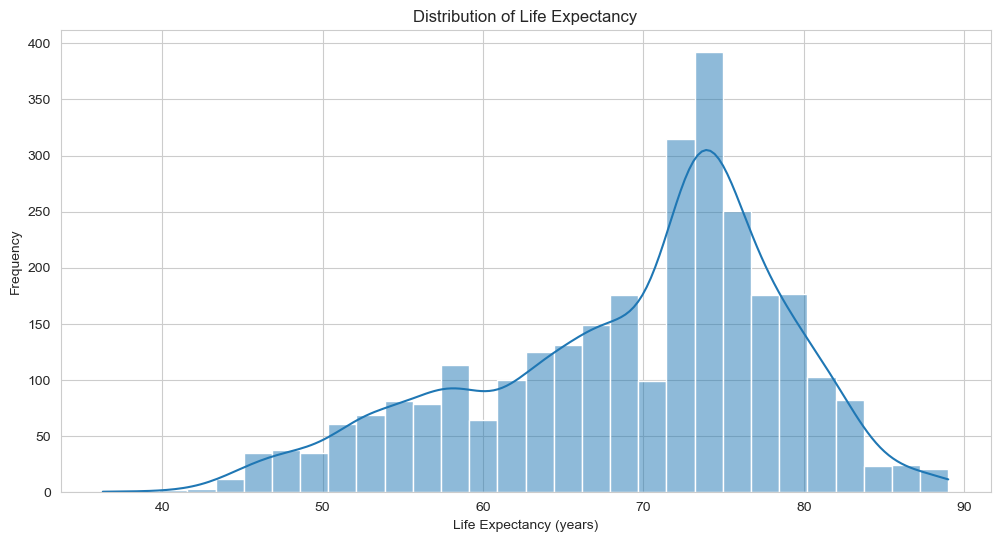

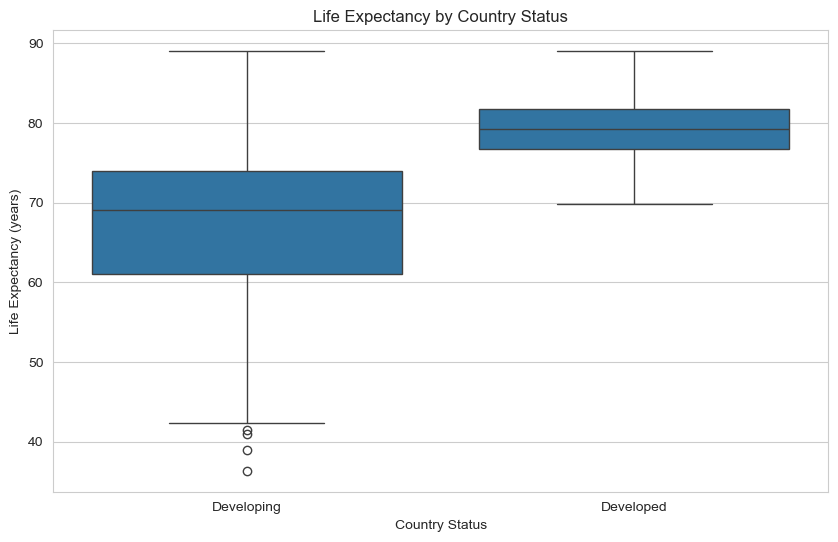

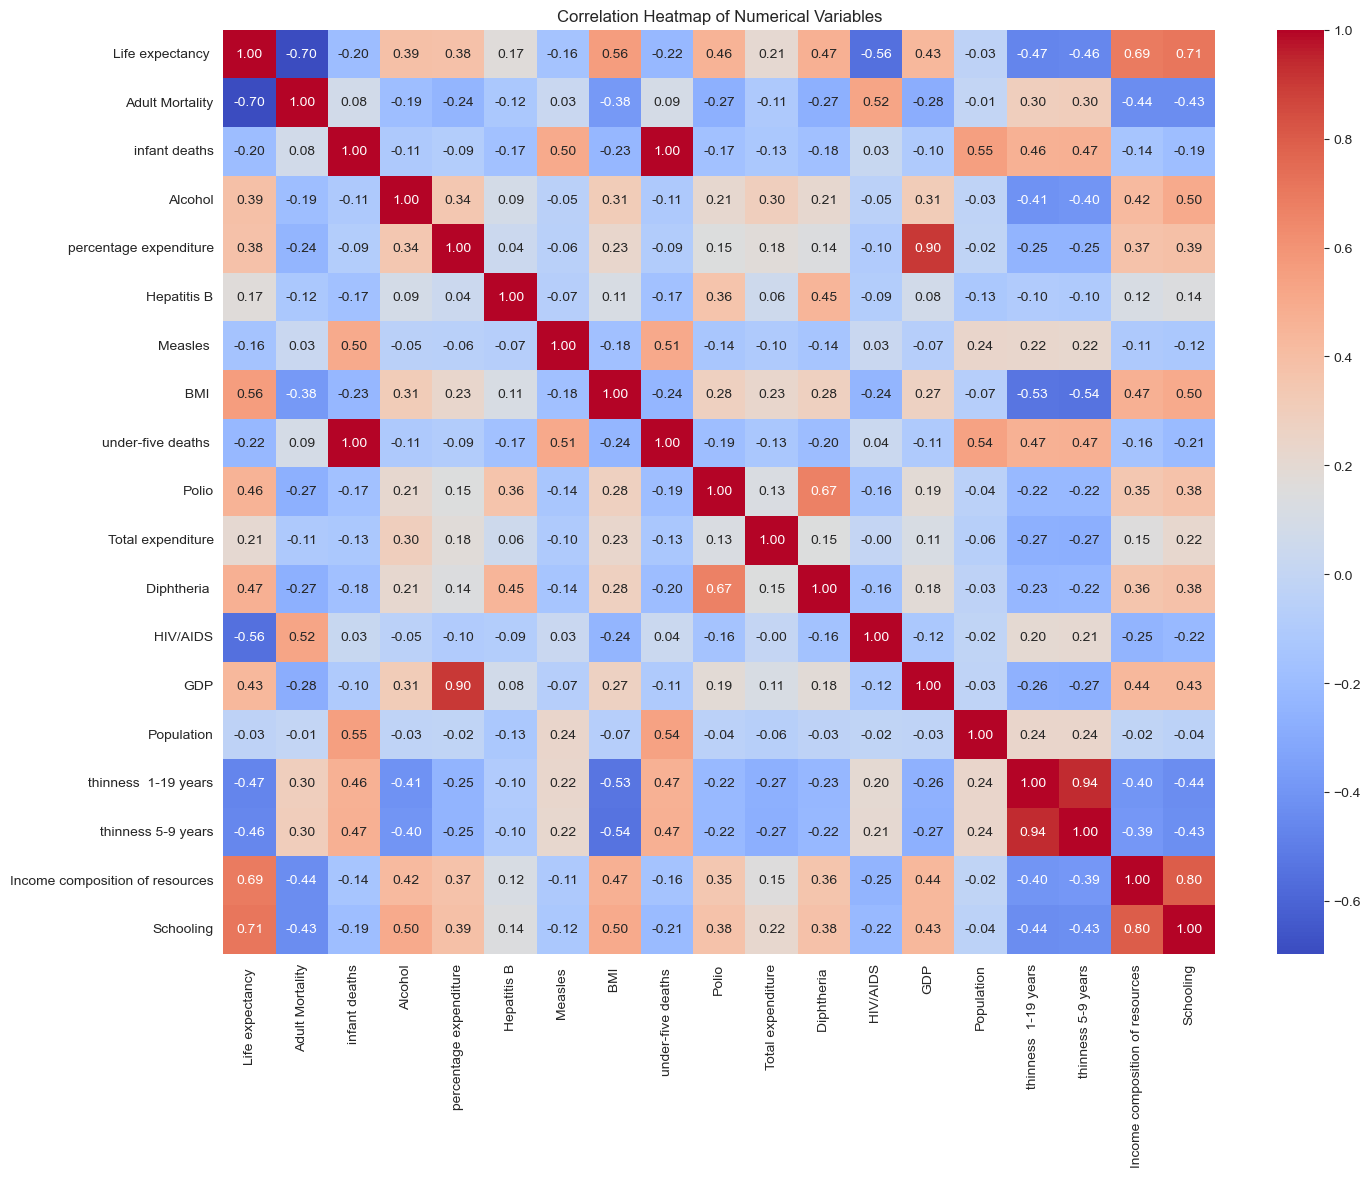

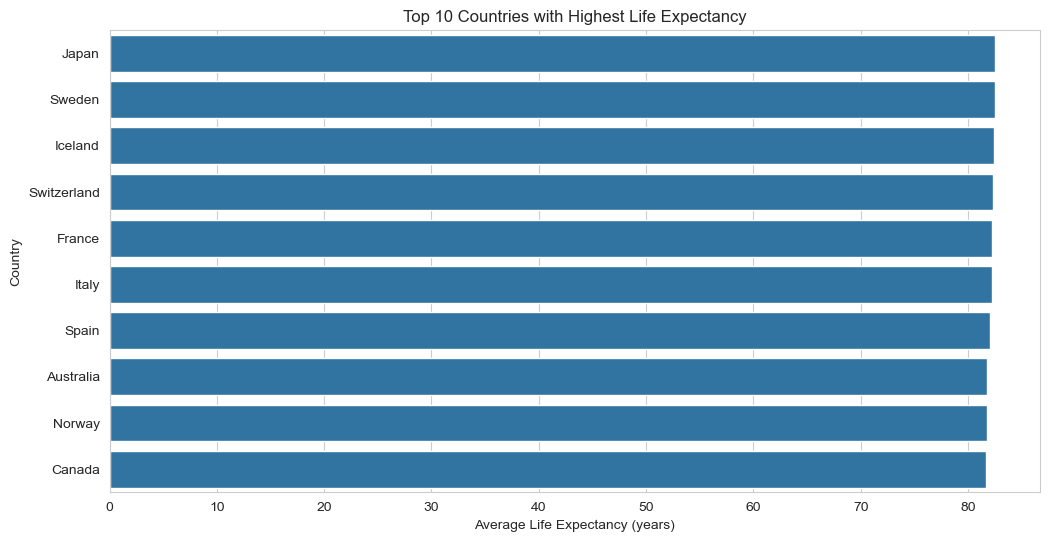

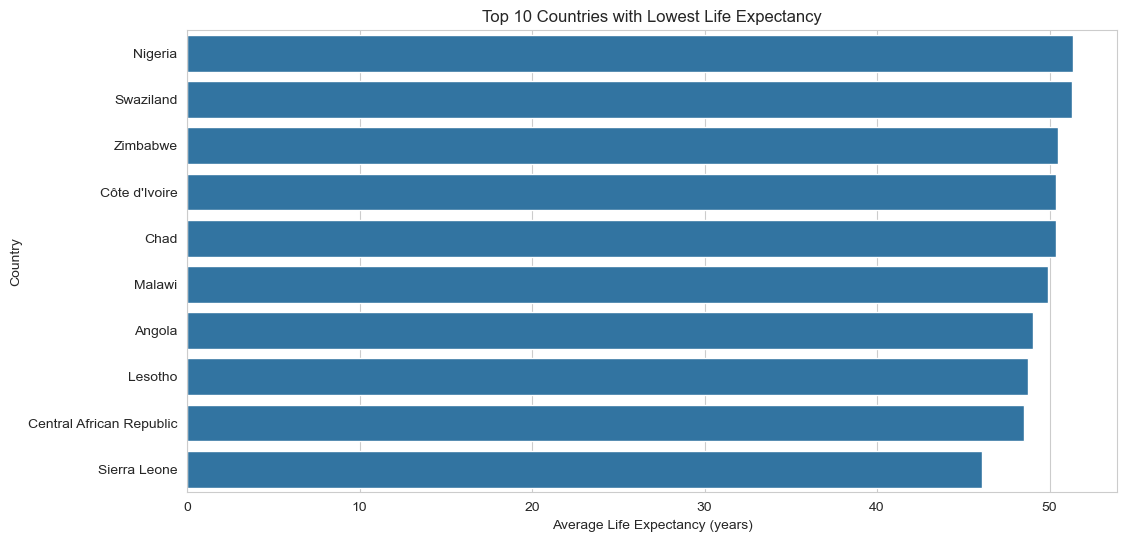

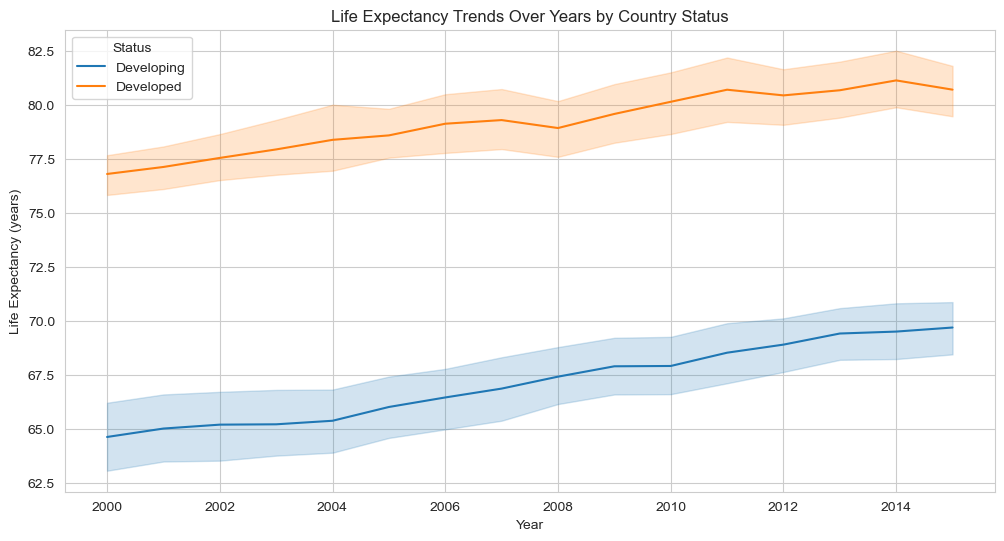

95% Confidence Interval for Life Expectancy: (68.89073106698916, 69.5787039227998)
90% Confidence Interval for Life Expectancy: (68.94606290492491, 69.52337208486405)
Mann-Whitney U Test: U=1136446.0, P-value=6.641112532820439e-192
Summary Statistics for Life Expectancy:
Mean: 69.23
Median: 72.10
Standard Deviation: 9.51
Minimum: 36.30
Maximum: 89.00
25th Percentile: 63.20
75th Percentile: 75.60


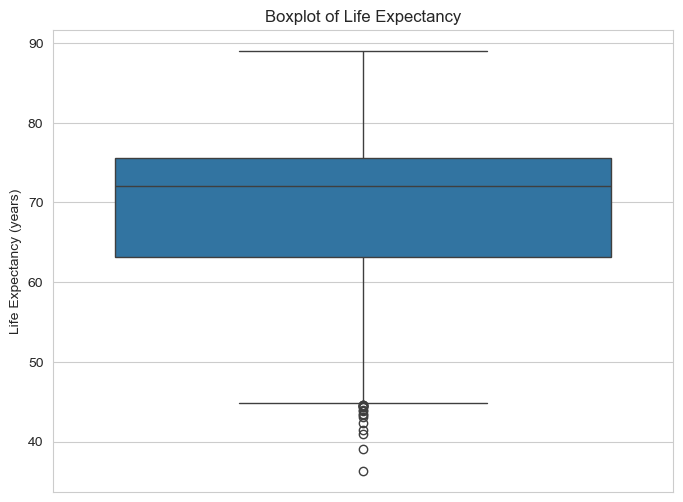

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Life expectancy '], kde=True, bins=30)
plt.title('Distribution of Life Expectancy')
plt.xlabel('Life Expectancy (years)')
plt.ylabel('Frequency')
plt.show()

# Life expectancy by country status
plt.figure(figsize=(10, 6))
sns.boxplot(x='Status', y='Life expectancy ', data=df)
plt.title('Life Expectancy by Country Status')
plt.xlabel('Country Status')
plt.ylabel('Life Expectancy (years)')
plt.show()

# Correlation heatmap (numerical columns only)
plt.figure(figsize=(16, 12))
corr = df[numeric_cols_for_outliers].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()

# Top 10 countries with highest and lowest life expectancy
top_countries = df.groupby('Country')['Life expectancy '].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.head(10).values, y=top_countries.head(10).index)
plt.title('Top 10 Countries with Highest Life Expectancy')
plt.xlabel('Average Life Expectancy (years)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.tail(10).values, y=top_countries.tail(10).index)
plt.title('Top 10 Countries with Lowest Life Expectancy')
plt.xlabel('Average Life Expectancy (years)')
plt.show()

# Life expectancy trends over years
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Life expectancy ', hue='Status', data=df)
plt.title('Life Expectancy Trends Over Years by Country Status')
plt.xlabel('Year')
plt.ylabel('Life Expectancy (years)')
plt.show()

# Confidence Intervals - 90%, 95%
sample = df['Life expectancy '].dropna()
mean = np.mean(sample)
conf_int = st.t.interval(0.95, df=len(sample)-1, loc=mean, scale=st.sem(sample))
print(f"95% Confidence Interval for Life Expectancy: {conf_int}")
conf_int = st.t.interval(0.90, df=len(sample)-1, loc=mean, scale=st.sem(sample))
print(f"90% Confidence Interval for Life Expectancy: {conf_int}")

# Non-Parametric Test - Mann Whitney U Test
group1 = df[df["Status"] == "Developed"]["Life expectancy "]
group2 = df[df["Status"] == "Developing"]["Life expectancy "]
u_stat, p_val = st.mannwhitneyu(group1, group2)
print(f"Mann-Whitney U Test: U={u_stat}, P-value={p_val}")

print("Summary Statistics for Life Expectancy:")
print(f"Mean: {df['Life expectancy '].mean():.2f}")
print(f"Median: {df['Life expectancy '].median():.2f}")
print(f"Standard Deviation: {df['Life expectancy '].std():.2f}")
print(f"Minimum: {df['Life expectancy '].min():.2f}")
print(f"Maximum: {df['Life expectancy '].max():.2f}")
print(f"25th Percentile: {df['Life expectancy '].quantile(0.25):.2f}")
print(f"75th Percentile: {df['Life expectancy '].quantile(0.75):.2f}")

# Boxplot for life expectancy distribution
plt.figure(figsize=(8, 6))
sns.boxplot(y='Life expectancy ', data=df)
plt.title('Boxplot of Life Expectancy')
plt.ylabel('Life Expectancy (years)')
plt.show()

### Statistical Inference
#### Univariate Analysis
Check normality of life expectancy

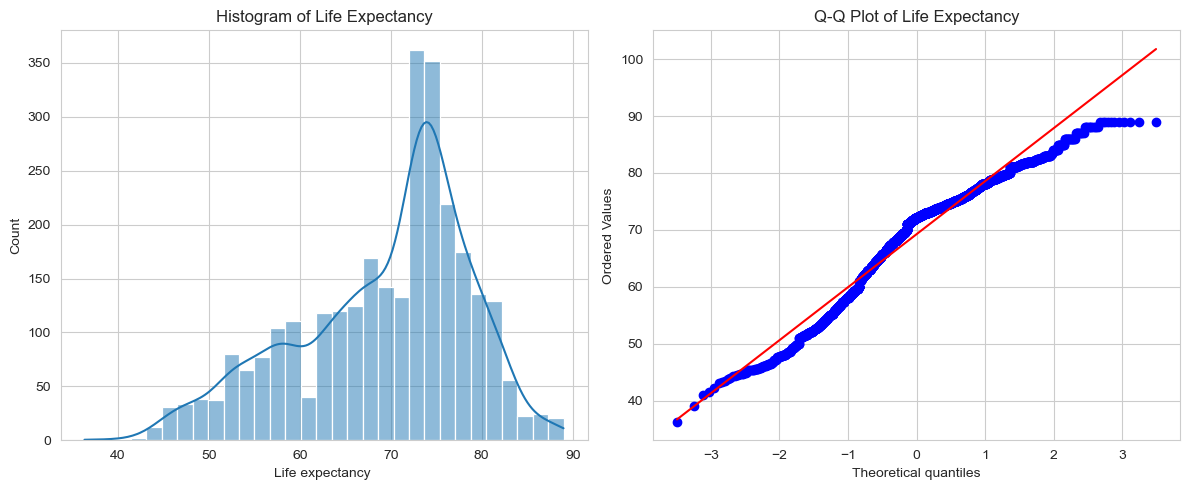


Shapiro-Wilk Test for Normality:
Test Statistic: 0.9557968389229173, p-value: 5.641373597047558e-29


In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Life expectancy '], kde=True)
plt.title('Histogram of Life Expectancy')

plt.subplot(1, 2, 2)
st.probplot(df['Life expectancy '], plot=plt)
plt.title('Q-Q Plot of Life Expectancy')
plt.tight_layout()
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = st.shapiro(df['Life expectancy '])
print("\nShapiro-Wilk Test for Normality:")
print(f"Test Statistic: {shapiro_test[0]}, p-value: {shapiro_test[1]}")

# Since p-value is very small (<0.05), we reject null hypothesis that data is normally distributed

### Multivariate Analysis

#### ANOVA for multiple groups (if we had more than 2 categories)
For demonstration, let's create income groups based on GDP

In [16]:
df['Income_Group'] = pd.qcut(df['GDP'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
anova = ols('Q("Life expectancy ") ~ C(Income_Group)', data=df).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)
print("\nANOVA for Life Expectancy across Income Groups:")
print(anova_table)

# Post-hoc test if ANOVA is significant
if anova_table['PR(>F)'][0] < 0.05:
    print("\nPost-hoc Tukey HSD Test:")
    tukey = pairwise_tukeyhsd(endog=df['Life expectancy '], groups=df['Income_Group'], alpha=0.05)
    print(tukey)


ANOVA for Life Expectancy across Income Groups:
                        sum_sq      df           F         PR(>F)
C(Income_Group)   79340.802393     3.0  416.658601  1.846974e-225
Residual         186232.336423  2934.0         NaN            NaN

Post-hoc Tukey HSD Test:


/var/folders/gk/xgky97s56xs9xq_8x2y8hlqm0000gn/T/ipykernel_23878/2144714712.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1   group2  meandiff p-adj  lower   upper  reject
------------------------------------------------------
  High       Low  -9.8348   0.0 -11.015 -8.6545   True
  High    Medium  -4.7586   0.0 -5.8811  -3.636   True
  High Very High   4.1386   0.0  2.9583  5.3188   True
   Low    Medium   5.0762   0.0   4.072  6.0804   True
   Low Very High  13.9733   0.0  12.905 15.0416   True
Medium Very High   8.8971   0.0  7.8929  9.9013   True
------------------------------------------------------


#### Numerical vs Numerical: Correlation and Regression
 Let's examine relationship between GDP and Life Expectancy

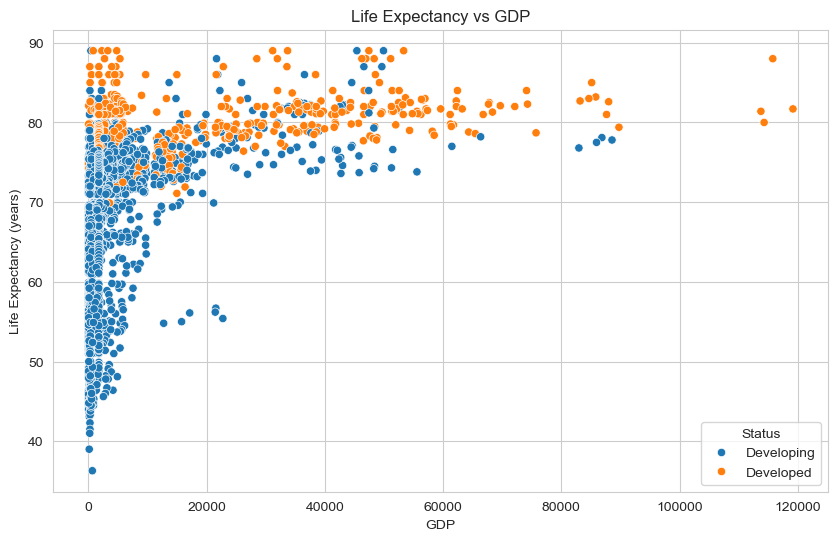


Pearson Correlation between GDP and Life Expectancy:
Correlation Coefficient: 0.430, p-value: 7.594371127599714e-133


In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GDP', y='Life expectancy ', hue='Status', data=df)
plt.title('Life Expectancy vs GDP')
plt.xlabel('GDP')
plt.ylabel('Life Expectancy (years)')
plt.show()

# Correlation test
pearson_corr = st.pearsonr(df['GDP'], df['Life expectancy '])
print("\nPearson Correlation between GDP and Life Expectancy:")
print(f"Correlation Coefficient: {pearson_corr[0]:.3f}, p-value: {pearson_corr[1]}")

### Simple linear regression

In [20]:
X = df[['GDP']]
y = df['Life expectancy ']
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
print("\nSimple Linear Regression Results (Life Expectancy ~ GDP):")
print(model.summary())



Simple Linear Regression Results (Life Expectancy ~ GDP):
                            OLS Regression Results                            
Dep. Variable:       Life expectancy    R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     667.8
Date:                Sun, 04 May 2025   Prob (F-statistic):          7.59e-133
Time:                        19:54:01   Log-Likelihood:                -10484.
No. Observations:                2938   AIC:                         2.097e+04
Df Residuals:                    2936   BIC:                         2.098e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

### Multiple linear regression with several predictors
Select relevant features based on correlation

In [22]:
features = ['Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 
            'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 
            'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', 
            ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 
            'Schooling']

# Encode categorical variable
le = LabelEncoder()
df['Status_encoded'] = le.fit_transform(df['Status'])
features.append('Status_encoded')

X = df[features]
y = df['Life expectancy ']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Multiple Linear Regression Performance:
RMSE: 3.91
R-squared: 0.82

Estimated Regression Equation:
y = 69.29 + (-2.60 * X1) + (10.85 * X2) + (0.22 * X3) + (0.10 * X4) + (-0.46 * X5) + (-0.26 * X6) + (0.82 * X7) + (-11.04 * X8) + (0.65 * X9) + (0.09 * X10) + (0.99 * X11) + (-2.42 * X12) + (0.51 * X13) + (-0.05 * X14) + (-0.43 * X15) + (0.08 * X16) + (1.24 * X17) + (2.07 * X18) + (-0.64 * X19) 


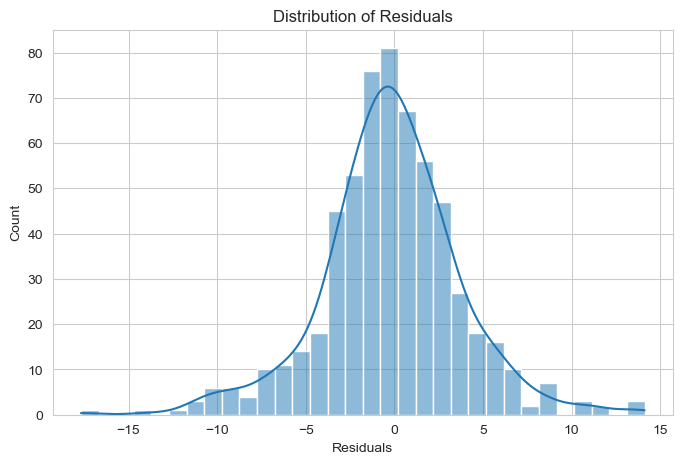


Feature Importance from Linear Regression:
                            Feature  Importance
1                     infant deaths   10.848321
17                        Schooling    2.072287
16  Income composition of resources    1.241047
10                      Diphtheria     0.988131
6                              BMI     0.820257
8                             Polio    0.649013
12                              GDP    0.509024
2                           Alcohol    0.218112
3            percentage expenditure    0.099897
9                 Total expenditure    0.087662
15               thinness 5-9 years    0.079904
13                       Population   -0.054444
5                          Measles    -0.264567
14             thinness  1-19 years   -0.434647
4                       Hepatitis B   -0.457241
18                   Status_encoded   -0.638305
11                         HIV/AIDS   -2.420930
0                   Adult Mortality   -2.598542
7                under-five deaths   -11.040

In [23]:
# Train the model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

# Print Performance Metrics
print("\nMultiple Linear Regression Performance:")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")  # Root Mean Squared Error
print(f"R-squared: {r_squared:.2f}")  # R-squared value

# Regression Coefficients and Intercept
print("\nEstimated Regression Equation:")
intercept = lr.intercept_
coefficients = lr.coef_

# Constructing the regression equation
regression_equation = f"y = {intercept:.2f} "  # Start with the intercept
for i, coef in enumerate(coefficients):
    regression_equation += f"+ ({coef:.2f} * X{i + 1}) "  # Assuming X1, X2, ..., Xn
print(regression_equation)

# Residual Analysis for Regression
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.show()

# Feature Importance
importance = pd.DataFrame({'Feature': features, 'Importance': lr.coef_})
importance = importance.sort_values('Importance', ascending=False)
print("\nFeature Importance from Linear Regression:")
print(importance)

print("\nInsights from the Linear Regression Model:")
print(f"- The estimated regression equation is: {regression_equation}")
print(f"- The model's performance is measured with an RMSE of {rmse:.2f}, which reflects the average error of our predictions.")
print(f"- An R-squared value of {r_squared:.2f} suggests that the model explains {r_squared * 100:.1f}% of the variance in the dependent variable.")
print(f"- Feature importance indicates how each feature contributes to predicting the target variable. Features with higher importance values are more influential in making predictions.")


### Random Forest for feature importance


Random Forest Regression Performance:
RMSE: 1.67
R-squared: 0.97

Feature Importance from Random Forest:
                            Feature  Importance
11                         HIV/AIDS    0.594131
16  Income composition of resources    0.163583
0                   Adult Mortality    0.143683
6                              BMI     0.018072
7                under-five deaths     0.012861
17                        Schooling    0.011872
15               thinness 5-9 years    0.009386
2                           Alcohol    0.006736
14             thinness  1-19 years    0.005245
9                 Total expenditure    0.005027
12                              GDP    0.004594
5                          Measles     0.004560
8                             Polio    0.003908
3            percentage expenditure    0.003697
10                      Diphtheria     0.003617
1                     infant deaths    0.003482
13                       Population    0.003338
4                       Hepati

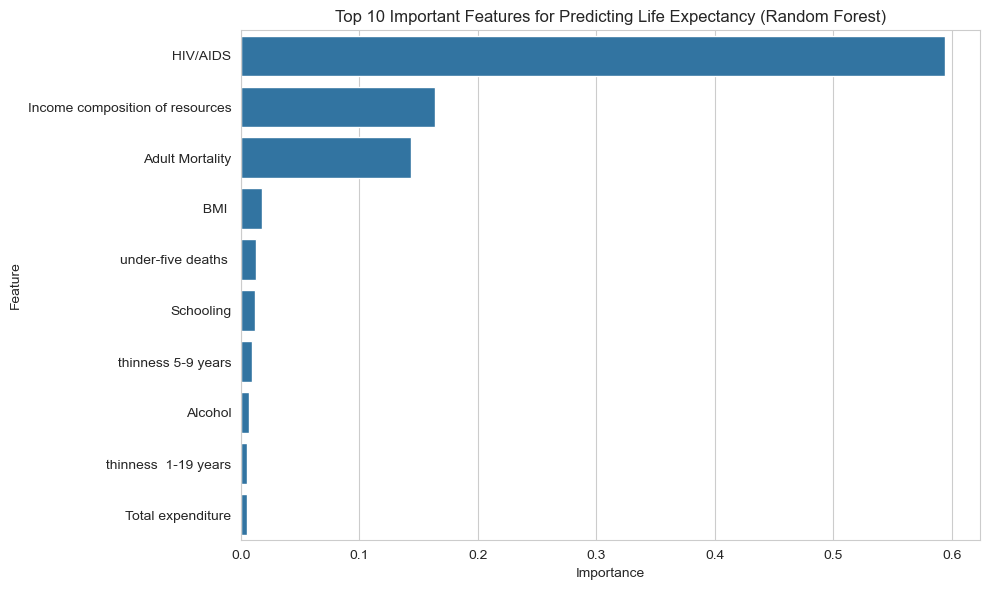

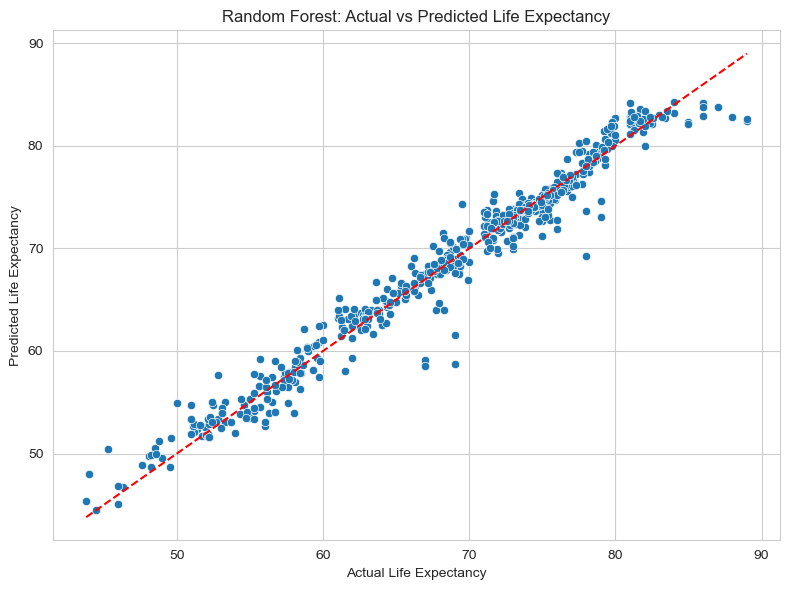

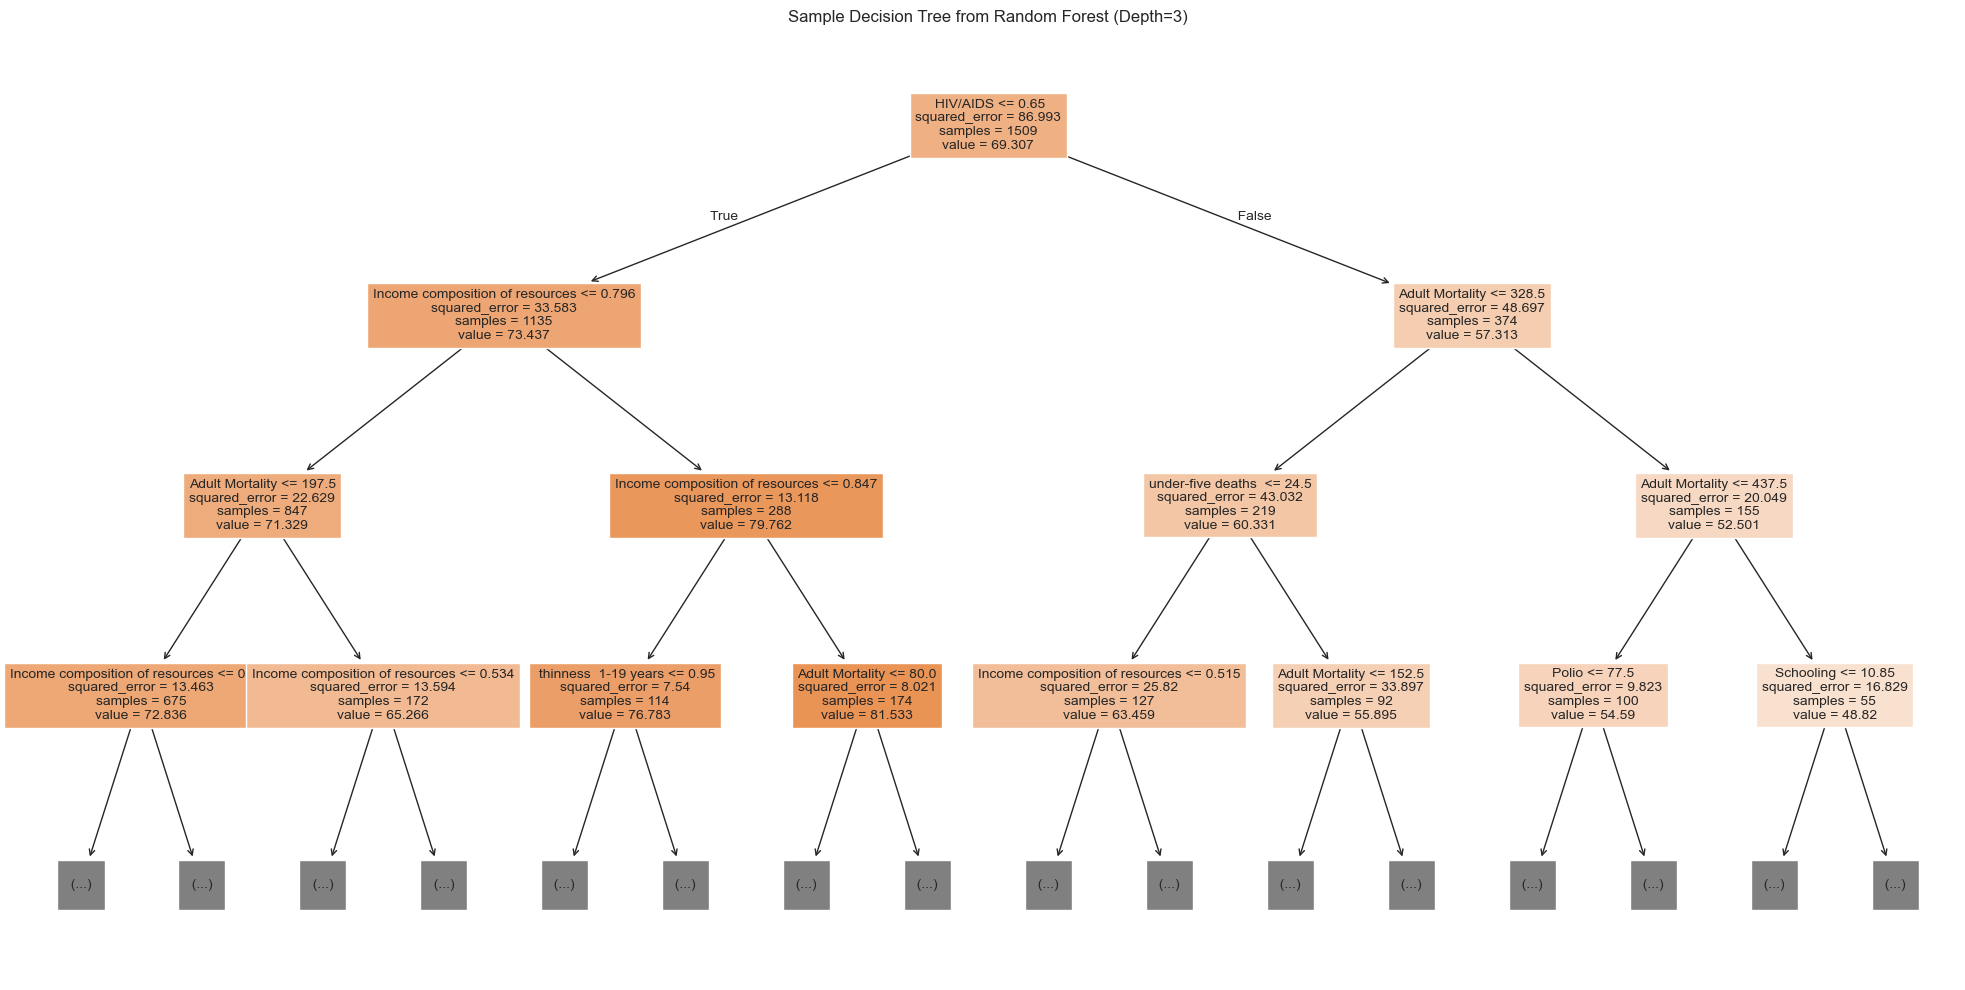

In [25]:
# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation Metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Regression Performance:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R-squared: {r2_rf:.2f}")

# Feature Importance
rf_importance = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
rf_importance = rf_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance from Random Forest:")
print(rf_importance)

# Top 10 Important Features Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importance.head(10))
plt.title('Top 10 Important Features for Predicting Life Expectancy (Random Forest)')
plt.tight_layout()
plt.show()

# Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal
plt.xlabel('Actual Life Expectancy')
plt.ylabel('Predicted Life Expectancy')
plt.title('Random Forest: Actual vs Predicted Life Expectancy')
plt.tight_layout()
plt.show()

# Visualize a single Decision Tree from the Random Forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], 
          feature_names=features, 
          filled=True, 
          max_depth=3, 
          fontsize=10)
plt.title("Sample Decision Tree from Random Forest (Depth=3)")
plt.tight_layout()
plt.show()

### Hypothesis Testing

Hypothesis 1: Z-test for Developed vs Developing Life Expectancy
Z-statistic: 47.87
p-value: 0.0000
Hypothesis 2: Chi-Square Test between Schooling and Life Expectancy
Chi-square Statistic: 2038.98
Degrees of Freedom: 9
p-value: 0.0000
Hypothesis 3: Chi-Square Test between BMI and Life Expectancy
Chi-square Statistic: 1287.86
Degrees of Freedom: 9
p-value: 0.0000
Hypothesis 4: Chi-Square Test between HIV/AIDS and Life Expectancy
Chi-square Statistic: 1849.29
Degrees of Freedom: 3
p-value: 0.0000


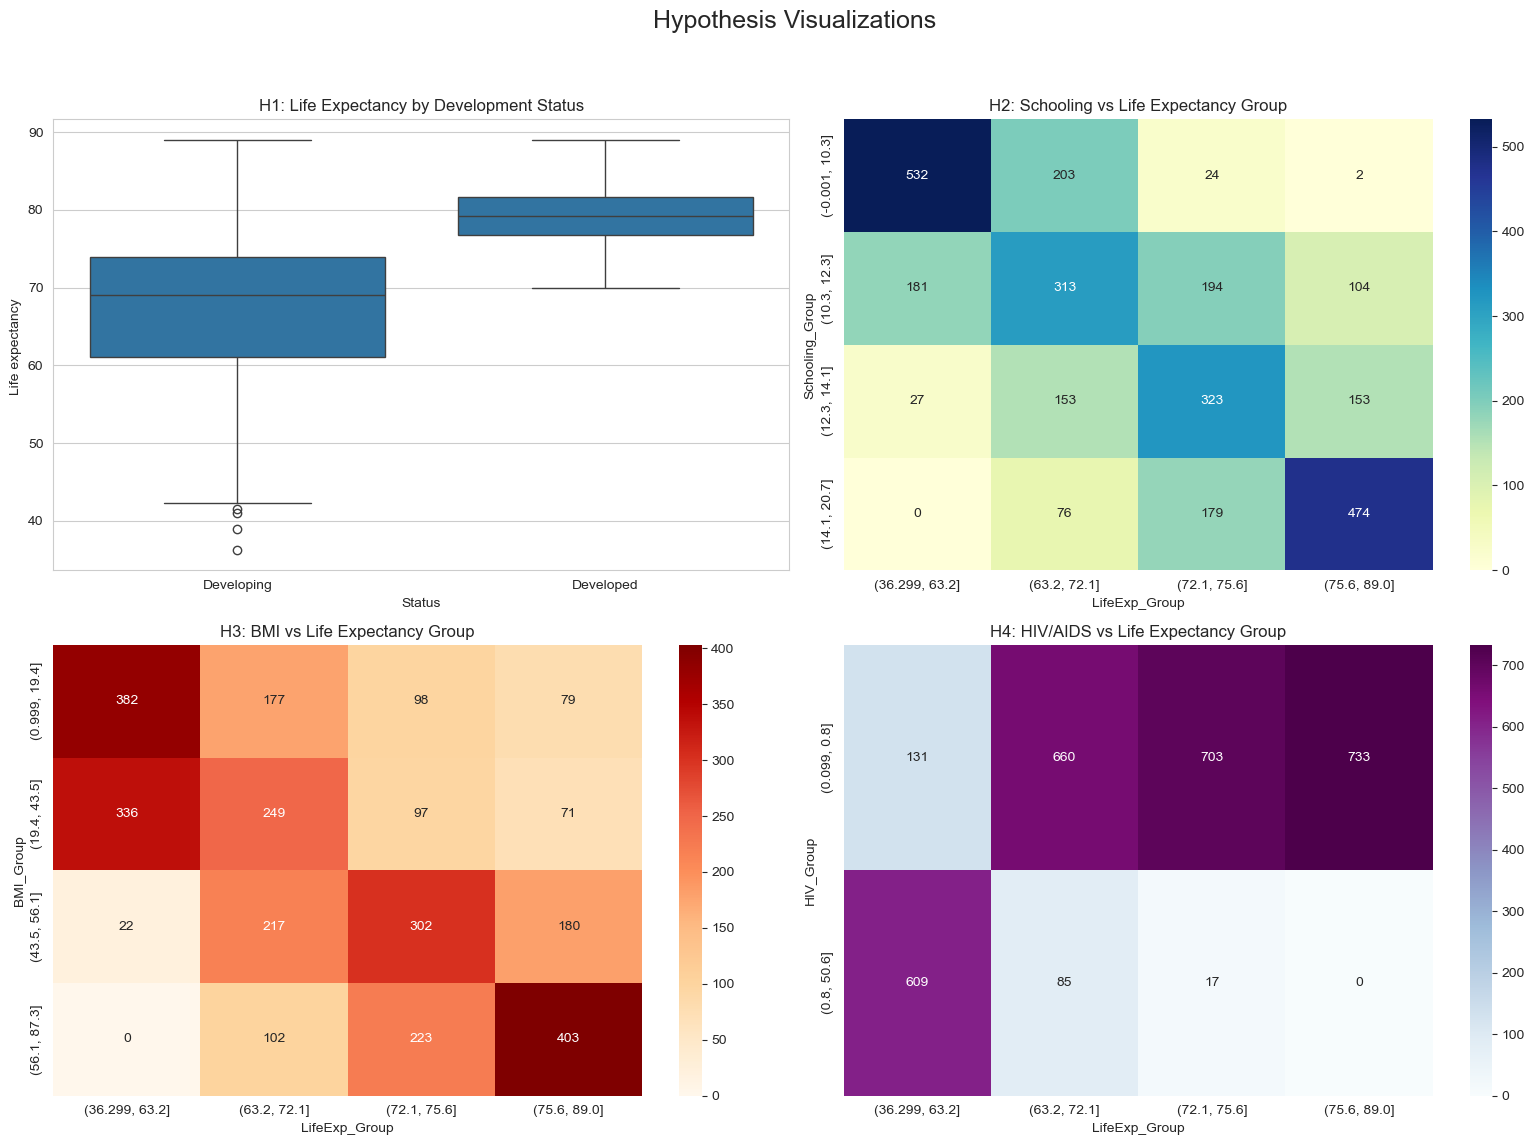

In [27]:
# Ensure groupings are created correctly with reduced bins for Schooling, BMI, and HIV/AIDS
df['LifeExp_Group'] = pd.qcut(df['Life expectancy '], q=4, duplicates='drop')  # Life Expectancy into 4 groups
df['Schooling_Group'] = pd.qcut(df['Schooling'], q=4, duplicates='drop')  # Schooling into 4 groups
df['BMI_Group'] = pd.qcut(df[' BMI '], q=4, duplicates='drop')  # BMI into 4 groups
df['HIV_Group'] = pd.qcut(df[' HIV/AIDS'], q=4, duplicates='drop')  # HIV/AIDS into 4 groups

# Set up 2x2 subplots for visualizations
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Hypothesis Visualizations', fontsize=18)

# Hypothesis 1: Z-test for Developed vs Developing Life Expectancy
developed_life_exp = df[df['Status'] == 'Developed']['Life expectancy ']
developing_life_exp = df[df['Status'] == 'Developing']['Life expectancy ']

# Calculate the means and standard deviations
mean_dev = developed_life_exp.mean()
mean_dev_std = developed_life_exp.std()
mean_dev_size = len(developed_life_exp)

mean_devg = developing_life_exp.mean()
mean_devg_std = developing_life_exp.std()
mean_devg_size = len(developing_life_exp)

# Calculate Z-statistic and p-value
pooled_std = (((mean_dev_std**2) / mean_dev_size) + ((mean_devg_std**2) / mean_devg_size))**0.5
z_stat = (mean_dev - mean_devg) / pooled_std
p_value = 2 * (1 - st.norm.cdf(abs(z_stat)))  # Two-tailed test

# Hypothesis 1: Boxplot of Life Expectancy by Development Status
sns.boxplot(x='Status', y='Life expectancy ', data=df, ax=axs[0, 0])
axs[0, 0].set_title('H1: Life Expectancy by Development Status')
print("Hypothesis 1: Z-test for Developed vs Developing Life Expectancy")
print(f"Z-statistic: {z_stat:.2f}")
print(f"p-value: {p_value:.4f}")

# Hypothesis 2: Chi-Square test and heatmap of Schooling vs Life Expectancy Groups
h2_ct = pd.crosstab(df['Schooling_Group'], df['LifeExp_Group'])
chi2_h2, p_h2, dof_h2, _ = chi2_contingency(h2_ct)
sns.heatmap(h2_ct, annot=True, fmt='d', cmap='YlGnBu', ax=axs[0, 1])
axs[0, 1].set_title('H2: Schooling vs Life Expectancy Group')
print("Hypothesis 2: Chi-Square Test between Schooling and Life Expectancy")
print(f"Chi-square Statistic: {chi2_h2:.2f}")
print(f"Degrees of Freedom: {dof_h2}")
print(f"p-value: {p_h2:.4f}")

# Hypothesis 3: Chi-Square test and heatmap of BMI vs Life Expectancy Groups
h3_ct = pd.crosstab(df['BMI_Group'], df['LifeExp_Group'])
chi2_h3, p_h3, dof_h3, _ = chi2_contingency(h3_ct)
sns.heatmap(h3_ct, annot=True, fmt='d', cmap='OrRd', ax=axs[1, 0])
axs[1, 0].set_title('H3: BMI vs Life Expectancy Group')
print("Hypothesis 3: Chi-Square Test between BMI and Life Expectancy")
print(f"Chi-square Statistic: {chi2_h3:.2f}")
print(f"Degrees of Freedom: {dof_h3}")
print(f"p-value: {p_h3:.4f}")

# Hypothesis 4: Chi-Square test and heatmap of HIV/AIDS vs Life Expectancy Groups
h4_ct = pd.crosstab(df['HIV_Group'], df['LifeExp_Group'])
chi2_h4, p_h4, dof_h4, _ = chi2_contingency(h4_ct)
sns.heatmap(h4_ct, annot=True, fmt='d', cmap='BuPu', ax=axs[1, 1])
axs[1, 1].set_title('H4: HIV/AIDS vs Life Expectancy Group')
print("Hypothesis 4: Chi-Square Test between HIV/AIDS and Life Expectancy")
print(f"Chi-square Statistic: {chi2_h4:.2f}")
print(f"Degrees of Freedom: {dof_h4}")
print(f"p-value: {p_h4:.4f}")

# Adjust layout to ensure everything fits
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Central Limit Theorem

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


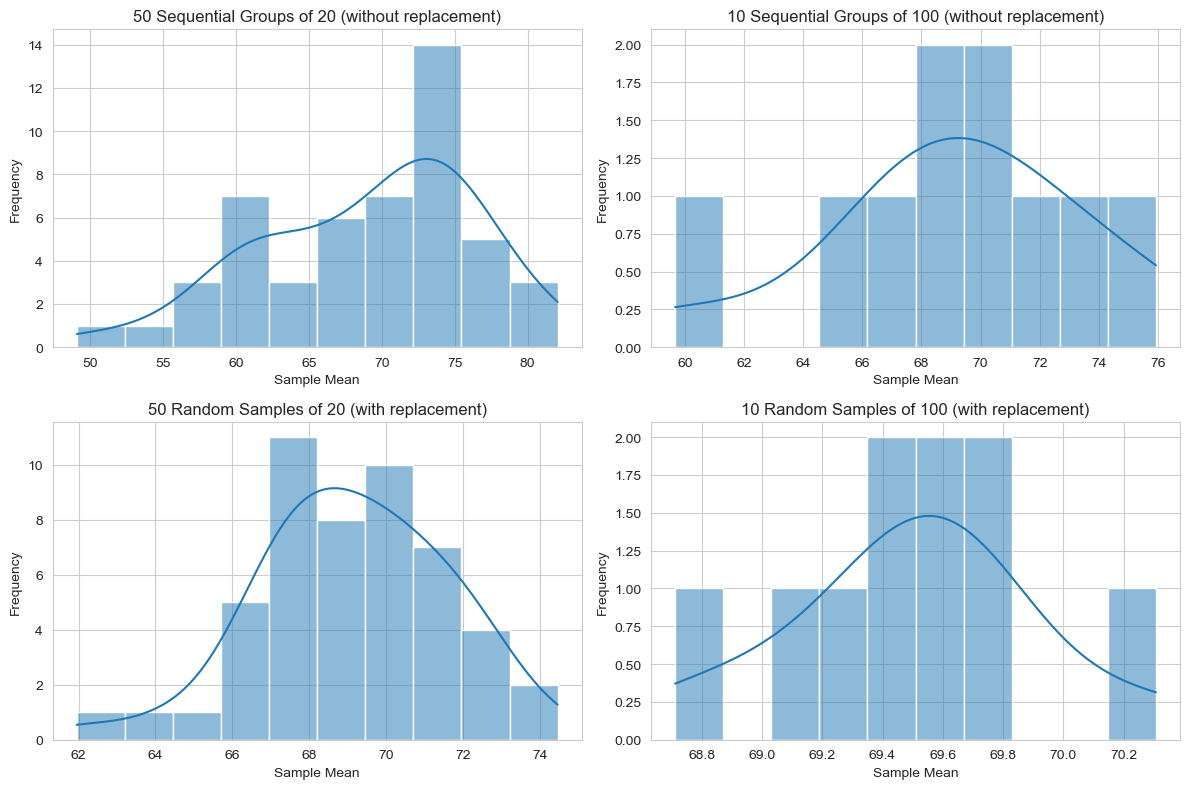

Summary of Sample Mean Distributions:

50 Sequential Groups of 20 (without replacement)
  Mean of Sample Means       : 69.06
  Std Dev of Sample Means    : 7.40
  Expected Std Dev (σ/√n)    : 2.13
--------------------------------------
10 Sequential Groups of 100 (without replacement)
  Mean of Sample Means       : 69.06
  Std Dev of Sample Means    : 4.50
  Expected Std Dev (σ/√n)    : 0.95
--------------------------------------
50 Random Samples of 20 (with replacement)
  Mean of Sample Means       : 69.14
  Std Dev of Sample Means    : 2.49
  Expected Std Dev (σ/√n)    : 2.13
--------------------------------------
10 Random Samples of 100 (with replacement)
  Mean of Sample Means       : 69.50
  Std Dev of Sample Means    : 0.43
  Expected Std Dev (σ/√n)    : 0.95
--------------------------------------


In [29]:
# Extract and clean life expectancy data
life_expectancy = df['Life expectancy '].dropna()
mu_pop = life_expectancy.mean()
sigma_pop = life_expectancy.std()

# Function to generate sample means
def sample_means(series, group_size, num_groups, random=False):
    if random:
        return [series.sample(group_size, replace=True).mean() for _ in range(num_groups)]
    else:
        return [group.mean() for group in np.array_split(series.iloc[:group_size * num_groups], num_groups)]

# Generate all four sampling distributions
groupings = [
    ("50 Sequential Groups of 20 (without replacement)", 20, 50, False),
    ("10 Sequential Groups of 100 (without replacement)", 100, 10, False),
    ("50 Random Samples of 20 (with replacement)", 20, 50, True),
    ("10 Random Samples of 100 (with replacement)", 100, 10, True)
]

results = []

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, (title, size, count, rand) in enumerate(groupings):
    means = sample_means(life_expectancy, size, count, rand)
    mean_val = np.mean(means)
    std_val = np.std(means, ddof=1)
    expected_std = sigma_pop / np.sqrt(size)
    results.append((title, mean_val, std_val, expected_std))

    ax = axs[i // 2, i % 2]
    sns.histplot(means, kde=True, bins=10, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Sample Mean")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of Sample Mean Distributions:\n")
for title, mean_val, std_val, expected_std in results:
    print(f"{title}")
    print(f"  Mean of Sample Means       : {mean_val:.2f}")
    print(f"  Std Dev of Sample Means    : {std_val:.2f}")
    print(f"  Expected Std Dev (σ/√n)    : {expected_std:.2f}")
    print("-" * 38)